In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')


In [4]:

# Convert date columns to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')


In [5]:
# Aggregate data to create customer profiles
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',              # Total revenue sum 
    'Quantity': 'sum',                # Total quantity  sum 
    'ProductID': lambda x: x.nunique(),  # unique products 
    'Category': lambda x: x.nunique()   #  unique categories 
}).reset_index()

customer_features.rename(columns={
    'TotalValue': 'TotalRevenue',
    'Quantity': 'TotalQuantity',
    'ProductID': 'UniqueProducts',
    'Category': 'UniqueCategories'
}, inplace=True)

# Merge customer based on Region
customer_profiles = pd.merge(customer_features, customers[['CustomerID', 'Region']], on='CustomerID')

# One-hot encode of the Region column
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'], drop_first=True)

# Normalizing
scaler = StandardScaler()
normalized_data = scaler.fit_transform(customer_profiles.drop('CustomerID', axis=1))

#  clustering 
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(normalized_data)

# clustering metrics
db_index = davies_bouldin_score(normalized_data, customer_profiles['Cluster'])
silhouette_avg = silhouette_score(normalized_data, customer_profiles['Cluster'])
ch_index = calinski_harabasz_score(normalized_data, customer_profiles['Cluster'])

print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")



Davies-Bouldin Index: 1.0653
Silhouette Score: 0.3414
Calinski-Harabasz Index: 82.9618


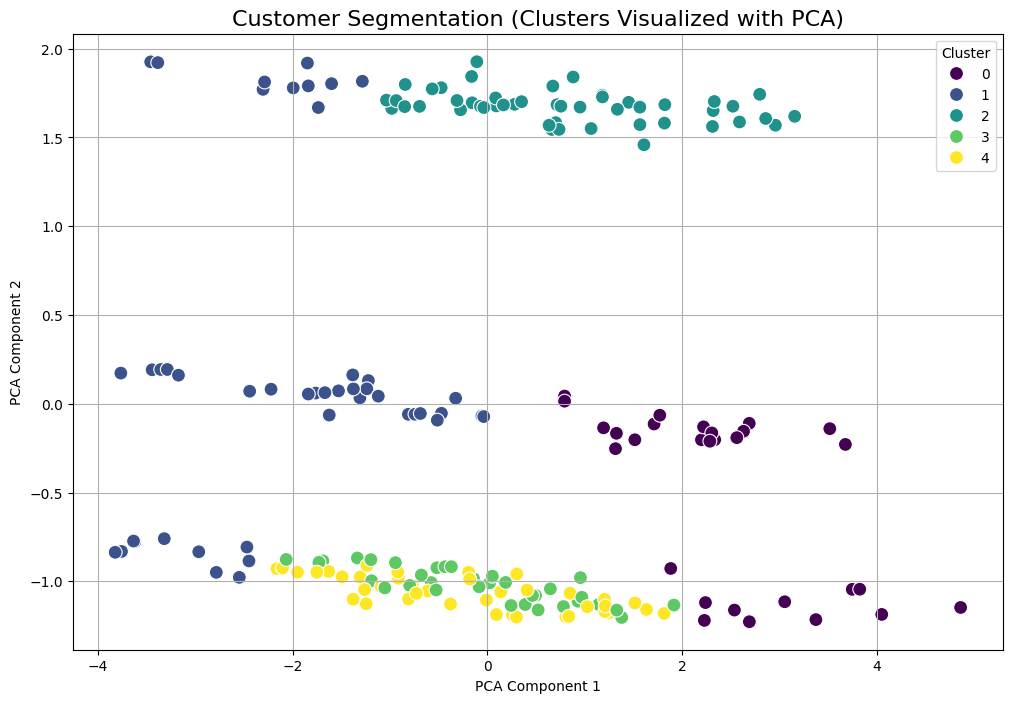

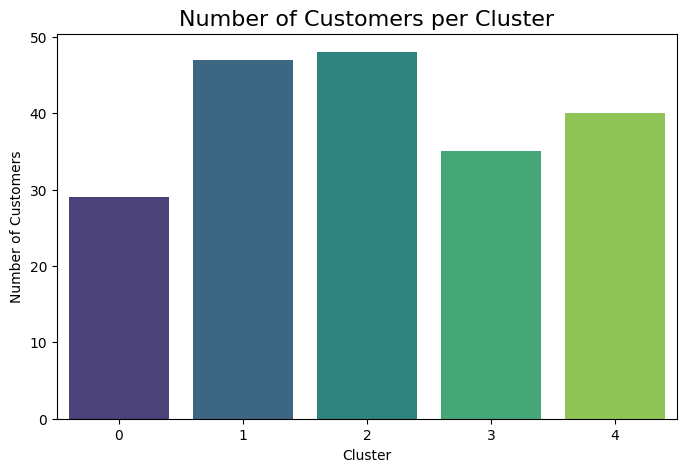

In [6]:

# Visualize Clusters with PCA (reduce to 2 dimensions)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_data)

# Add PCA components to the DataFrame
customer_profiles['PCA1'] = pca_result[:, 0]
customer_profiles['PCA2'] = pca_result[:, 1]

# Plot clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    data=customer_profiles,
    palette='viridis',
    s=100
)
plt.title('Customer Segmentation (Clusters Visualized with PCA)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.grid()
plt.show()

# Visualize cluster sizes
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=customer_profiles, palette='viridis')
plt.title('Number of Customers per Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


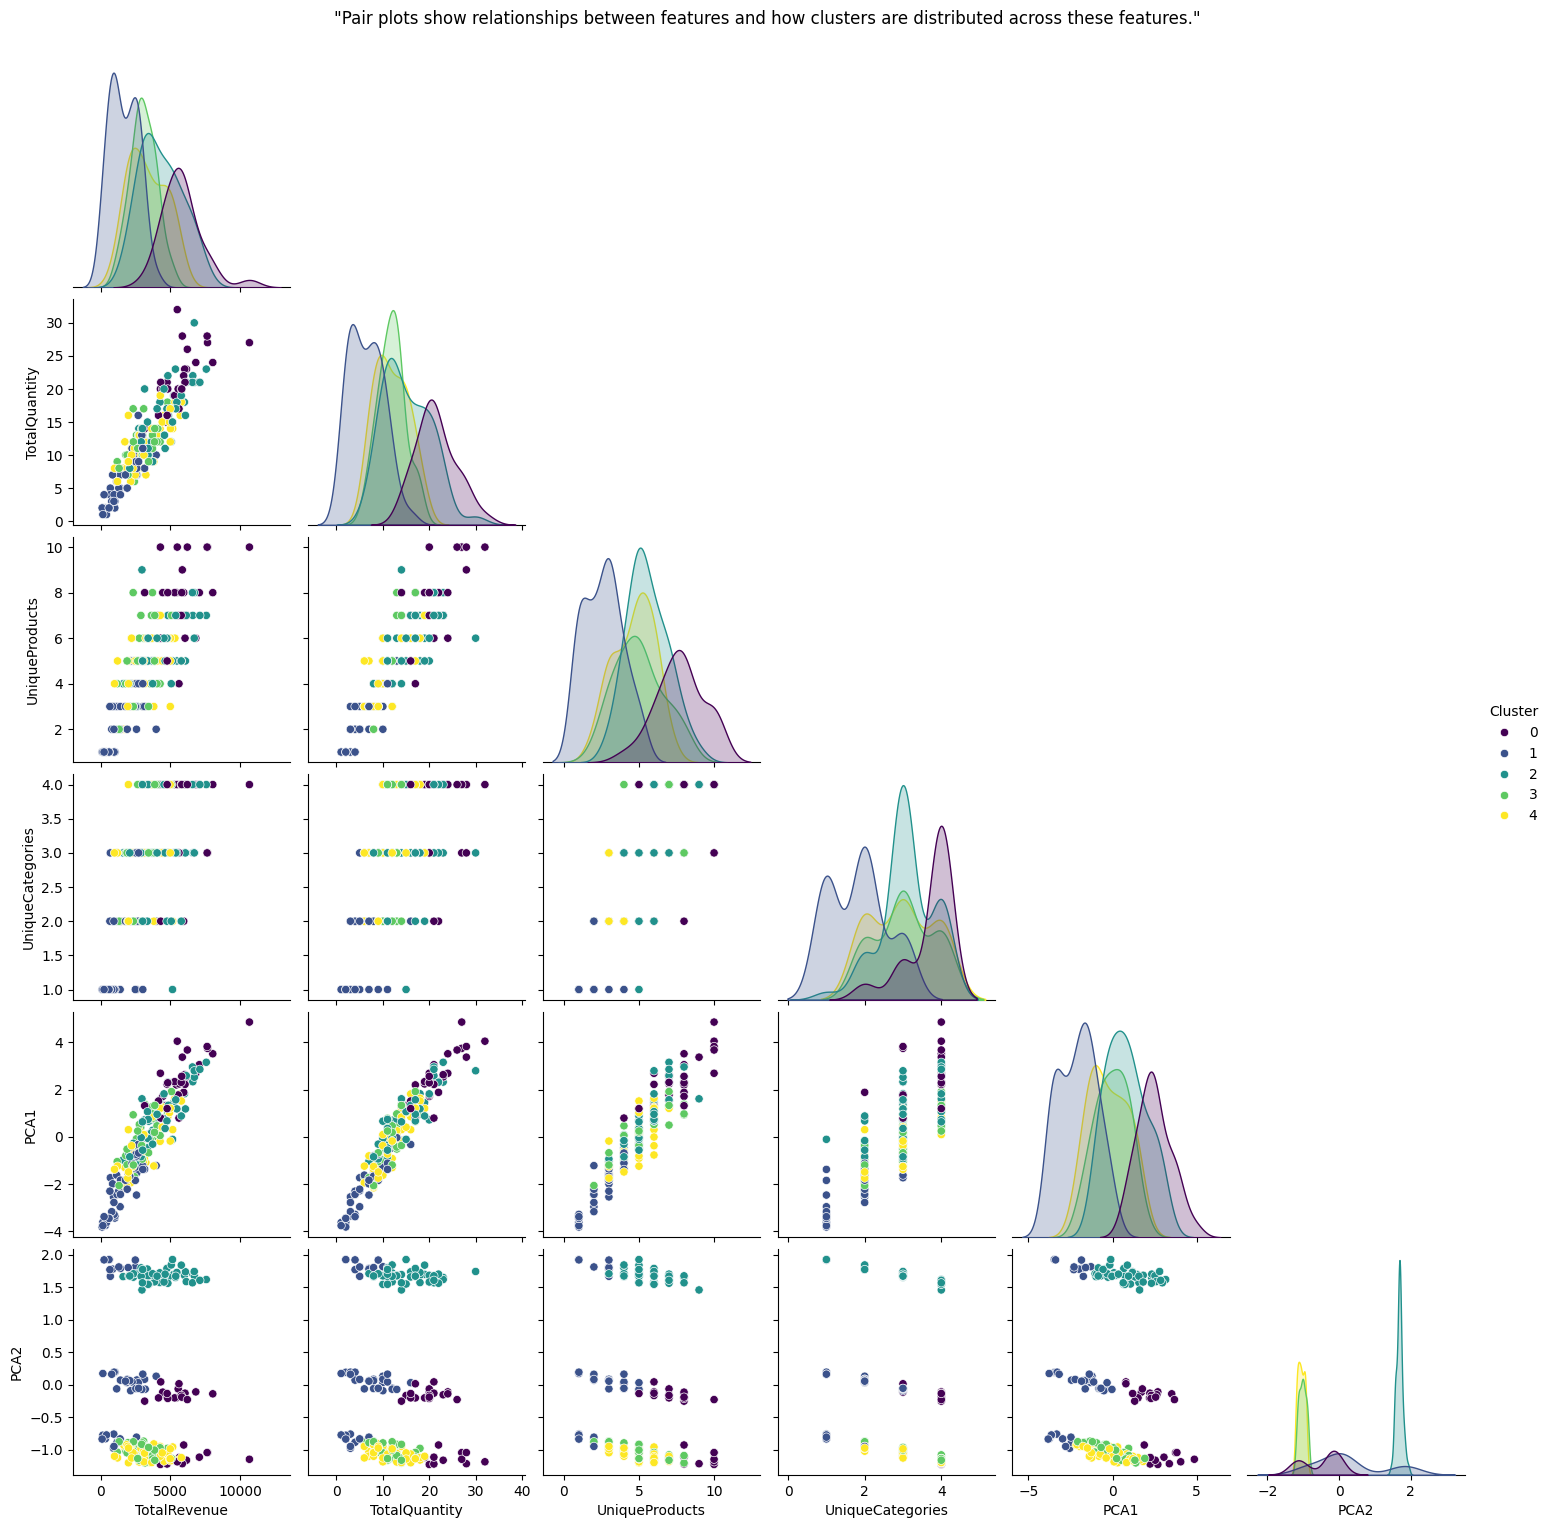

In [10]:
# Pair Plots for Cluster Profiling
numeric_columns = customer_profiles.select_dtypes(include=[np.number]).columns
cluster_features = customer_profiles[numeric_columns]
sns.pairplot(cluster_features, hue='Cluster', palette='viridis', corner=True)
plt.suptitle('"Pair plots show relationships between features and how clusters are distributed across these features."', y=1.02)
plt.show()